In [ ]:
# default_exp exposure
%reload_ext autoreload
%autoreload 2

# Exposure processing
> Add exposure to each event

In [ ]:
#export
def contiguous(start, stop, min_gap=2, ):
    assert len(start)==len(stop)
    ssint = np.empty(2*len(start), float)
    ssint[0::2] = start
    ssint[1::2] = stop
    
    # Tag the (stpp,start) pairs < 10 sec as  not adjacent
    not_adjacent = np.diff(ssint)[1::2] > min_gap ;
    
    # make a mask, keep ends
    mask = np.empty(len(ssint), bool)
    mask[0] = mask[-1] = True
    # 

    # insert into mask -- keep only the (stop,start) pairs  which are not adjacent
    mask[1:-2:2] = not_adjacent
    mask[2:-1:2] = not_adjacent
    
    # apply mask, split into start and stop
    keep = ssint[mask]
    return keep

In [ ]:
#hide
teststart = np.array([0,1,2,4,6,7, 11], float)
teststop =  np.array([1,2,4,5,7,8, 12], float)
expect = np.array([0,8,11,12])
assert (contiguous(teststart, teststop)==expect).all()

In [ ]:
#export
sec_per_day = 24*3600
def add_exposure_to_events(config, exposure, photons):
    """
    
    """
    # get interleaved start/stop pairs for contiguous intervals
    estop = exposure.stop.values
    etime = estart =exposure.start.values

    run_times = contiguous(estart, estop, min_gap=10/sec_per_day)
    fermi_start = run_times[0]
    fermi_stop = run_times[-1]
    if config.verbose>1:
        print(f'Found {len(run_times)//2:,} contiguous intervals, interpret as runs'
              f' from {UTC(fermi_start)[:10]} to {UTC(fermi_stop)[:10]}')

    ### Determine run exposures
    vexp = exposure.exp.values /1e4 # exposure per FT2 interval -- in m^2 
    cumexp = np.insert(np.cumsum(vexp), 0,0)
    if verbose>1: print(f'Total exposure: {cumexp[-1]*1e-6:.1f}  m^2 Ms')

    run_index = np.searchsorted(estart, run_times)
    run_start_exp = cumexp[run_index][0::2]

#     run_exp_diff = np.diff(run_start_exp)

    ### Assign Event exposure from event times

    if config.verbose>1: print(f'Examine {len(photons):,} photons.')

    event = photons#['time weight'.split()].copy()
    event_exposure = cumexp[np.searchsorted(estart, event.time)]
    event.loc[:,'tau'] = np.diff(np.insert(event_exposure,0,0))
    return pd.DataFrame(dict(time=run_times[0::2], exp=run_start_exp))

### Test

SourceData: photons and exposure for 3C 279: Restoring from cache with key "3C 279_data"
SourceData: Source 3C 279 with:
	 data:       179,695 photons from 2008-08-04 to 2021-04-21
	 exposure: 2,817,749 intervals,  average rate 2935 cm^2 for 84.1 Ms
	 rates:  source 4.03e-07/s, background 3.25e-07/s, S/N ratio 1.24
Found 70,767 contiguous intervals, interpret as runs from 2008-08-04 to 2021-04-20
Total exposure: 24.7  m^2 Ms
Examine 179,695 photons.


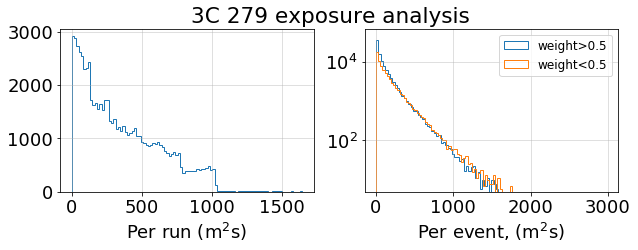

In [ ]:
#hide
from wtlike.source_data import *
from wtlike.config import *
wtl = SourceData('3C 279')

exposure = wtl.exposure
photons = wtl.photons
source_name = wtl.source_name
verbose = wtl.config.verbose = 2


runs = add_exposure_to_events(wtl.config, wtl.exposure, wtl.photons)
run_start_exp = runs.exp.values

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,3))

ax1.hist(np.diff(run_start_exp), bins = 100)
ax1.set(xlabel = r'Per run $\mathrm{(m^2 s)}$')
ax1.grid(alpha=0.5);
ax = ax2
bins = 100 #np.linspace(0,2000,100)
ax.hist(photons.tau[photons.weight>0.5], bins=bins, log=True, label='weight>0.5');
ax.hist(photons.tau[photons.weight<0.5], bins=bins, log=True, label='weight<0.5');
ax.legend(fontsize=12)
ax.set(xlabel=r'Per event, $\mathrm{(m^2 s)}$', ylim=(5,None))
ax.grid(alpha=0.5);
fig.suptitle(f'{source_name} exposure analysis');